In [ ]:
!pip install category_encoders

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gspread
from google.auth import default
import io
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import joblib
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve, precision_score, recall_score

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder



# Set the option to display all columns
pd.set_option('display.max_columns', None)

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DATA COLLECTION PROCESS

1. Road Traffic Accident Data

The accident dataset is generated from official road safety reports that capture all recorded traffic incidents across Nigerian states.
For each reported case, multiple levels of severity and outcomes are documented, including:

- Fatal, Serious, and Minor cases

- Number Injured and Number Killed

- Total Casualties and People Involved

Additionally, each accident entry contains coded causative factors such as:

- Speed violation (SPV)

- Brake failure (BFL)

- Overloading (OVL)

- Bad roads (BRD)

- Dangerous driving (DGD)

- Poor weather (PWR)

  And several others

These factors reflect what the reporting officers identified as the primary contributors to the accident.
The data is timestamped using YEAR and QUARTER (derived from monthly accident dates) and is aggregated to provide state-level summaries of accident severity and causation.

2. Weather and Environmental Data (MERRA-2 + CERES Satellite Data)

The environmental dataset is sourced from NASA’s MERRA-2 and CERES SYN1Deg atmospheric reanalysis products.
These datasets provide monthly, gridded climate variables for each 0.5° × 0.625° latitude–longitude cell, which is matched to Nigerian state coordinates.

Key meteorological parameters include:

- Precipitation (mm/day)

- Surface Pressure (kPa)

- Specific Humidity at 2m (g/kg)

- Temperature at 2m and Dew Point (°C)

- Earth Skin Temperature (°C)

- Wind Speed & Direction (2m and 10m)

- Cloud Amount (%) from CERES

- Surface UV index and Total PAR (radiation energy)

- Soil Wetness (GWETTOP), etc.

Missing values from the satellite computations (e.g., areas where measurement is not possible) are represented as -999, which are removed or imputed before analysis.

In [ ]:

def get_data_from_spreadsheet(sheet_id, other_column):

  """
    Loads all worksheets from a Google Spreadsheet into a single DataFrame.

    Each worksheet's data is appended with a column indicating the worksheet name
    (or another identifier), then all worksheets are concatenated into one DataFrame.
  """
  # 1. Authenticate with Google Sheets
  creds, _ = default()
  gc = gspread.authorize(creds)

  from google.colab import auth
  auth.authenticate_user()

  # 2. Open the spreadsheet by ID
  spreadsheet = gc.open_by_key(sheet_id)

  # 3. Prepare an empty list to store DataFrames from each sheet
  dfs = []

  # 4. Loop through all worksheets
  for worksheet in spreadsheet.worksheets():
      # Get all data as a list of lists
      data = worksheet.get_all_values()

      # Skip empty sheets
      if not data:
          continue

      # Extract header row and remaining rows
      headers = data[0]
      rows = data[1:]

      # 5. Convert to DataFrame
      df = pd.DataFrame(rows, columns=headers)

      # 6. Add a column containing the worksheet name
      df[other_column] = worksheet.title.strip()

      # 7. Append to the list
      dfs.append(df)

  # 8. Concatenate all sheets vertically (axis=0)
  if dfs:
      result_df = pd.concat(dfs, axis=0, ignore_index=True)
  else:
      # Return an empty DataFrame if no worksheets had data
      result_df = pd.DataFrame()

  return result_df

In [ ]:
data_dict = {
    "PS": "Surface Pressure (kPa)",
    "QV2M": "Specific Humidity at 2 Meters (g/kg)",
    "T2M": "Temperature at 2 Meters (C)",
    "TS": "Earth Skin Temperature (C)",
    "WD2M": "Wind Direction at 2 Meters (Degrees)",
    "WS2M": "Wind Speed at 2 Meters (m/s)",
    "PRECTOTCORR": "Precipitation Corrected (mm/day)",
    "CLOUD_AMT": "Cloud Amount (%)",
    "GWETTOP": "Surface Soil Wetness (1)",
    "ALLSKY_SFC_UV_INDEX": "All Sky Surface UV Index (W m-2 x 40)",
    "T2MDEW": "Dew/Frost Point at 2 Meters (C)",
    "ALLSKY_SFC_PAR_TOT": "All Sky Surface Total PAR (MJ/m^2/day)",
    "WS10M_RANGE": "Wind Speed at 10 Meters Range (m/s)"
}

# Convert to DataFrame
df_data_dictionary = pd.DataFrame(
    list(data_dict.items()),
    columns=["Parameter", "Description"]
)
df_data_dictionary

,Parameter,Description
0,PS,Surface Pressure (kPa)
1,QV2M,Specific Humidity at 2 Meters (g/kg)
2,T2M,Temperature at 2 Meters (C)
3,TS,Earth Skin Temperature (C)
4,WD2M,Wind Direction at 2 Meters (Degrees)
5,WS2M,Wind Speed at 2 Meters (m/s)
6,PRECTOTCORR,Precipitation Corrected (mm/day)
7,CLOUD_AMT,Cloud Amount (%)
8,GWETTOP,Surface Soil Wetness (1)
9,ALLSKY_SFC_UV_INDEX,All Sky Surface UV Index (W m-2 x 40)


In [ ]:

accidents_causative_factors = pd.read_csv(io.StringIO('''
,
CAUSATIVE FACTORS,CODE
Speed Violation (SPV),SPV
Use of Phone While Driving (UPWD),UPWD
Tyre Burst (TBT),TBT
Mechanically Deficient Vehicle (MDV),MDV
Brake Failure (BFL),BFL
Overloading (OVL),OVL
Dangerous Overtaking (DOT),DOT
Wrongful Overtaking (WOT),WOT
Dangerous Driving (DGD),DGD
Bad Road (BRD),BRD
Route Violation (RTV),RTV
Road Obstruction Violation (OBS),OBS
Sleeping on Steering (SOS),SOS
Driving Under Alcohol/Drug Influence (DAD),DAD
Poor Weather (PWR),PWR
Fatigue (FTQ),FTQ
Sign Light Violation (SLV),SLV
Others,OTH
'''), header=1)


## DATA EXPLORATION

In [ ]:
# load the road traffic data
road_traffic_data = get_data_from_spreadsheet('1pFBrmnI1da_-cLkqMrS762eOqNWtmeQBDjEXDtaaVWc', 'DATE') # invoke te function to read road accidents data, and add a new column to track the date the accident occured

# load the weather data
weather_data = get_data_from_spreadsheet('1KKfzGKZvnYJnzhLdiRwyDefgICCYzV1PFUJGyhd7fu8', "STATE")  # invoke te function to read weather data, and add a new column to track the location


In [ ]:
road_traffic_data.sample(1)

,STATE,FATAL,SERIOUS,MINOR,TOTAL CASES,NUMBER INJURED,NUMBER KILLED,TOTAL CASUALTY,PEOPLE INVOLVED,SPV,UPD,TBT,MDV,BFL,OVL,DOT,WOT,DGD,BRD,RTV,OBS,SOS,DAD,PWR,FTQ,SLV,OTHERS,DATE,,LOC,WOV,DOV,ROV
217,Rivers,5,19,5,29,58,7,65,157,20,0,4,1,3,0,0,2,3,0,4,0,0,0,0,0,0,1,Q1-2022,NaN,NaN,NaN,NaN,NaN


In [ ]:
weather_data.sample(1)

,PARAMETER,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANN,STATE
645,GWETTOP,2023,0.7,0.63,0.65,0.66,0.64,0.78,0.8,0.76,0.78,0.8,0.77,0.68,0.72,CROSS RIVER


In [ ]:
def clean_road_traffic_data(road_traffic_df):

  """
    Cleans and preprocesses raw road traffic accident data for analysis or modeling.

    This function performs the following steps:
    1. Subsets the dataframe to only include relevant columns from 'STATE' to 'DATE'.
    2. Converts numeric accident-related columns to integers for consistency and calculations.
    3. Extracts the QUARTER and YEAR from the 'DATE' column.
       - Assumes 'DATE' is in the format 'Qx-YYYY' (e.g., 'Q1-2023') or similar.
    4. Drops the original 'DATE' column as it is no longer needed after extraction.
  """


  # 1. Keep only relevant columns from 'STATE' to 'DATE'
  road_traffic_df = road_traffic_df.loc[:, "STATE":"DATE"]

  # 2. Convert all accident-related numeric columns to integer type
  #    Skips the first column (STATE) and converts the next 26 columns
  for col in road_traffic_df.columns.tolist()[1:27]:
      road_traffic_df[col] = road_traffic_df[col].astype(int)

  # 3. Extract QUARTER from the DATE column
  road_traffic_df["QUARTER"] = road_traffic_df["DATE"].str.split("-").str[0]


  # 4. Extract YEAR from the DATE column
  road_traffic_df["YEAR"] = road_traffic_df["DATE"].str.split("-").str[1]
  # road_traffic_df["STATE"] =  road_traffic_df["STATE"].str.replace("RIVERS", "Cross River")
  road_traffic_df["STATE"] = road_traffic_df["STATE"].apply(lambda x : x.upper())


  # 5. Drop the original DATE column, as QUARTER and YEAR are sufficient
  return road_traffic_df.drop("DATE", axis=1)

In [ ]:
cleaned_road_traffic_data = clean_road_traffic_data(road_traffic_data) # preprocessed road traffic data
cleaned_road_traffic_data.sample()

,STATE,FATAL,SERIOUS,MINOR,TOTAL CASES,NUMBER INJURED,NUMBER KILLED,TOTAL CASUALTY,PEOPLE INVOLVED,SPV,UPD,TBT,MDV,BFL,OVL,DOT,WOT,DGD,BRD,RTV,OBS,SOS,DAD,PWR,FTQ,SLV,OTHERS,QUARTER,YEAR
631,AKWA IBOM,4,5,1,10,10,7,17,27,11,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,1,Q1,2025


The `clean_road_traffic_data` function prepares raw road accident data for analysis by transforming it into a clean and structured format. First, it selects only the relevant columns, from `STATE` to `DATE`, ensuring the dataset focuses on accident metrics and key identifiers while removing unnecessary information. Next, all accident-related columns are converted to integers, guaranteeing that metrics like fatalities, injuries, and total cases can be correctly aggregated or used in calculations.

The function then extracts the quarter and year from the "DATE" column, which is in this format `Qx-YYYY`. The quarter is stored in a new `QUARTER` column, allowing for easy seasonal trend analysis, while the year is stored in a YEAR column, enabling year-over-year comparisons and facilitating merges with other datasets, such as weather or traffic data. Finally, the original `DATE` column is dropped, keeping the dataframe clean and focused. Overall, the preprocessing results in a dataset that is ready for aggregation, visualization, or machine learning modeling.

In [ ]:
def load_states_coords(state_coords):
    """
    Load state coordinates from a JSON file or string and return a cleaned DataFrame.

    Parameters:
    state_coords : str or path-like
        Path to the JSON file or JSON string containing state coordinates.

    Returns:
    pd.DataFrame
        DataFrame with columns: 'State', 'lat', 'lon'.
    """

    # Read the JSON data and transpose it so that states become rows
    data = pd.read_json(state_coords).T

    # Rename columns to 'lat' for latitude and 'lon' for longitude
    data.columns = ["lat", "lon"]

    # Name the index as 'State' for clarity
    data.index.name = "STATE"; data = data.reset_index()
    data['STATE'] = data['STATE'].str.upper()



    # Reset the index so 'State' becomes a regular column
    return data

state_coordinates = load_states_coords("/content/drive/MyDrive/FRSC Accident Forecasting Project/state_coords.json")

In [ ]:
def clean_weather_data(weather_df):

    """
      Cleans and reshapes raw monthly weather data. This function performs the following steps:

        1. Drops unnecessary columns that are not relevant for analysis.
        2. Converts monthly weather data from strings to numeric values.
        3. Transforms the dataset from wide format (one column per month) to long format (one row per month) for easier manipulation.
        4. Pivots the dataset so that each weather parameter becomes its own column, with one row per state, year, and month.
        5. Cleans up column names to remove unnecessary prefixes.
        6. Extracts the quarter (Q1-Q4) from the month for aggregation or seasonal analysis.
        7. Weather readings are aggregated by STATE, YEAR, and QUARTER using the mean,
          producing one record per quarter with averaged meteorological measurements.
          This prepares the data for integration with quarterly accident datasets.

    """

    # 1. Drop the annual summary column
    weather_df = weather_df.drop("ANN", axis=1)

    # 2. Identify JAN–DEC columns and convert them to numeric
    month_cols = weather_df.columns.tolist()[2:14]
    weather_df[month_cols] = weather_df[month_cols].apply(pd.to_numeric, errors='coerce')

    # 3. Convert wide month columns into long format
    melted_weather_data = weather_df.melt(
        id_vars=['PARAMETER', 'YEAR', 'STATE'],
        value_vars=month_cols,
        var_name='MONTH',
        value_name='VALUE'
    )

    # 4. Pivot PARAMETER values into separate columns
    pivoted_weather_data = melted_weather_data.pivot_table(
        index=['STATE', 'YEAR', 'MONTH'],
        columns='PARAMETER',
        values='VALUE'
    ).reset_index()

    # 5. Clean parameter column names
    pivoted_weather_data.columns = pivoted_weather_data.columns.str.replace('PARAMETER_', '', regex=False)

    # 6. Convert month abbreviation → quarter
    pivoted_weather_data['QUARTER'] = (
        'Q' + pd.to_datetime(pivoted_weather_data['MONTH'], format='%b')
                      .dt.quarter
                      .astype(str)
    )


    # 7. Merge coordinates and normalize state names
    # merged_weather_data = (
    #     pivoted_weather_data
    #     .merge(state_coordinates, on="STATE", how="left")
    #     .drop("MONTH", axis=1)
    # )
    merged_weather_data = (
        pivoted_weather_data
        .drop("MONTH", axis=1)
    )
    merged_weather_data["STATE"] = merged_weather_data["STATE"].apply(lambda x: x.upper())

    # 8. Replace placeholder -999 values with NaN and remove rows containing them
    merged_weather_data = merged_weather_data.replace(-999, np.nan).dropna()

    # 9. Aggregate data quarterly
    aggregated_weather_data = (
        merged_weather_data.groupby(["STATE", "YEAR", "QUARTER"])
        .mean(numeric_only=True)
        .reset_index()
    )

    renamed_agg_column_names = aggregated_weather_data.rename({
        "PS":"Surface Pressure (kPa)",
        "QV2M":"Specific Humidity at 2 Meters (g/kg)",
        "T2M":"Temperature at 2 Meters (C)",
        "TS":"Earth Skin Temperature (C)",
        "WD2M":"Wind Direction at 2 Meters (Degrees)",
        "WS2M":"Wind Speed at 2 Meters (m/s)",
        "PRECTOTCORR":"Precipitation Corrected (mm/day)",
        "CLOUD_AMT":"deg Cloud Amount (%)",
        "GWETTOP":"Surface Soil Wetness (1)",
        "ALLSKY_SFC_UV_INDEX":"All Sky Surface UV Index (W m-2 x 40)",
        "T2MDEW":"Dew/Frost Point at 2 Meters (C)",
        "ALLSKY_SFC_PAR_TOT":"All Sky Surface Total PAR (MJ/m^2/day)",
        "ALLSKY_SFC_UV_INDEX":"All Sky Surface UV Index (W m-2 x 40)",
        "WS10M_RANGE":"Wind Speed at 10 Meters Range (m/s)"

      }, axis=1)

    return renamed_agg_column_names

In [ ]:
cleaned_weather_data = clean_weather_data(weather_data) # preprocessed weather data

cleaned_weather_data.sample()

PARAMETER,STATE,YEAR,QUARTER,All Sky Surface Total PAR (MJ/m^2/day),All Sky Surface UV Index (W m-2 x 40),deg Cloud Amount (%),Surface Soil Wetness (1),Precipitation Corrected (mm/day),Surface Pressure (kPa),Specific Humidity at 2 Meters (g/kg),Temperature at 2 Meters (C),Dew/Frost Point at 2 Meters (C),Earth Skin Temperature (C),Wind Direction at 2 Meters (Degrees),Wind Speed at 10 Meters Range (m/s),Wind Speed at 2 Meters (m/s)
688,PLATEAU,2021,Q3,8.226667,1.94,79.403333,0.82,8.78,95.27,16.833333,23.593333,21.4,23.643333,233.933333,2.61,1.643333


In [ ]:
# merge accidents data with weather stats.
# This ensures all traffic records remain available while enriching them with matching weather data.

weather_accidents_df = cleaned_road_traffic_data.merge(cleaned_weather_data, on=["STATE", "YEAR", "QUARTER"], how="left")

weather_accidents_df.sample()

,STATE,FATAL,SERIOUS,MINOR,TOTAL CASES,NUMBER INJURED,NUMBER KILLED,TOTAL CASUALTY,PEOPLE INVOLVED,SPV,UPD,TBT,MDV,BFL,OVL,DOT,WOT,DGD,BRD,RTV,OBS,SOS,DAD,PWR,FTQ,SLV,OTHERS,QUARTER,YEAR,All Sky Surface Total PAR (MJ/m^2/day),All Sky Surface UV Index (W m-2 x 40),deg Cloud Amount (%),Surface Soil Wetness (1),Precipitation Corrected (mm/day),Surface Pressure (kPa),Specific Humidity at 2 Meters (g/kg),Temperature at 2 Meters (C),Dew/Frost Point at 2 Meters (C),Earth Skin Temperature (C),Wind Direction at 2 Meters (Degrees),Wind Speed at 10 Meters Range (m/s),Wind Speed at 2 Meters (m/s)
351,KADUNA,65,129,9,203,782,139,921,1730,109,0,11,3,0,0,1,17,26,3,16,0,0,0,0,8,0,1,Q1,2023,9.29,1.92,31.083333,0.503333,3.65,94.11,8.156667,23.166667,8.89,22.996667,69.6,4.13,3.046667


In [ ]:
weather_accidents_df.shape

(703, 42)

The `clean_weather_data` function converts raw monthly weather measurements into a clean, structured, and analytics-ready dataset. It begins by removing unnecessary fields, such as the annual summary (ANN), and ensures all monthly values are numeric to support reliable calculations. The data is then reshaped from a wide format with separate columns for each month into a long format where each row represents a single month for a given state, year, and weather parameter. After reshaping, the dataset is pivoted so that each weather parameter becomes its own column, resulting in a tidy structure with one row per state, year, and month. Column names are cleaned for clarity, and a QUARTER field is derived from the month to support seasonal trend analysis.

Next, the function merges geographic coordinates for each state, enabling spatial modeling or mapping. It also removes placeholder values such as `-999`, ensuring only valid weather readings are used. A key enhancement of this pipeline is the aggregation step: weather parameters are averaged across each state–year–quarter combination. This quarterly aggregation is crucial because it produces a consistent structure that aligns with the road accident dataset, which is also reported quarterly. By summarizing weather patterns at the same temporal resolution as the accident data, the resulting dataset provides richer context for analyzing how environmental conditions might influence accident severity or fatalities. Ultimately, the function outputs a clean, numeric, quarterly-aggregated, and spatially-enhanced dataset that is immediately suitable for merging with road accident records and building meaningful predictive or explanatory models.

After cleaning both datasets, the road traffic data and weather data were integrated to enable combined analysis. The merge was performed using the STATE, YEAR, and QUARTER columns to ensure proper alignment of records across both datasets. A left join was used so that all road traffic records are retained even if corresponding weather information is missing.

## DATA EXPLORATION

In [ ]:
weather_accidents_df.sample()

,STATE,FATAL,SERIOUS,MINOR,TOTAL CASES,NUMBER INJURED,NUMBER KILLED,TOTAL CASUALTY,PEOPLE INVOLVED,SPV,UPD,TBT,MDV,BFL,OVL,DOT,WOT,DGD,BRD,RTV,OBS,SOS,DAD,PWR,FTQ,SLV,OTHERS,QUARTER,YEAR,All Sky Surface Total PAR (MJ/m^2/day),All Sky Surface UV Index (W m-2 x 40),deg Cloud Amount (%),Surface Soil Wetness (1),Precipitation Corrected (mm/day),Surface Pressure (kPa),Specific Humidity at 2 Meters (g/kg),Temperature at 2 Meters (C),Dew/Frost Point at 2 Meters (C),Earth Skin Temperature (C),Wind Direction at 2 Meters (Degrees),Wind Speed at 10 Meters Range (m/s),Wind Speed at 2 Meters (m/s)
201,IMO,7,16,3,26,54,17,71,134,5,0,3,0,7,0,0,1,1,0,0,0,0,0,0,0,10,0,Q1,2022,8.02,1.653333,60.686667,0.756667,1.986667,100.23,16.496667,25.773333,21.55,25.59,192.366667,2.493333,1.38


NASA/POWER Source Native Resolution Monthly and Annual
Dates (month/day/year): 01/01/2020 through 12/31/2025 in LST
Location: Latitude  5.4527   Longitude 7.5248
Elevation from MERRA-2: Average for 0.5 x 0.625 degree lat/lon region = 92.75 meters
The value for missing source data that cannot be computed or is outside of the sources availability range: -999
Parameter(s):

PRECTOTCORR     | MERRA-2 Precipitation Corrected (mm/day)

PS              | MERRA-2 Surface Pressure (kPa)

QV2M            | MERRA-2 Specific Humidity at 2 Meters (g/kg)

T2M             | MERRA-2 Temperature at 2 Meters (C)

TS              | MERRA-2 Earth Skin Temperature (C)

WD2M            | MERRA-2 Wind Direction at 2 Meters (Degrees)

WS2M            | MERRA-2 Wind Speed at 2 Meters (m/s)

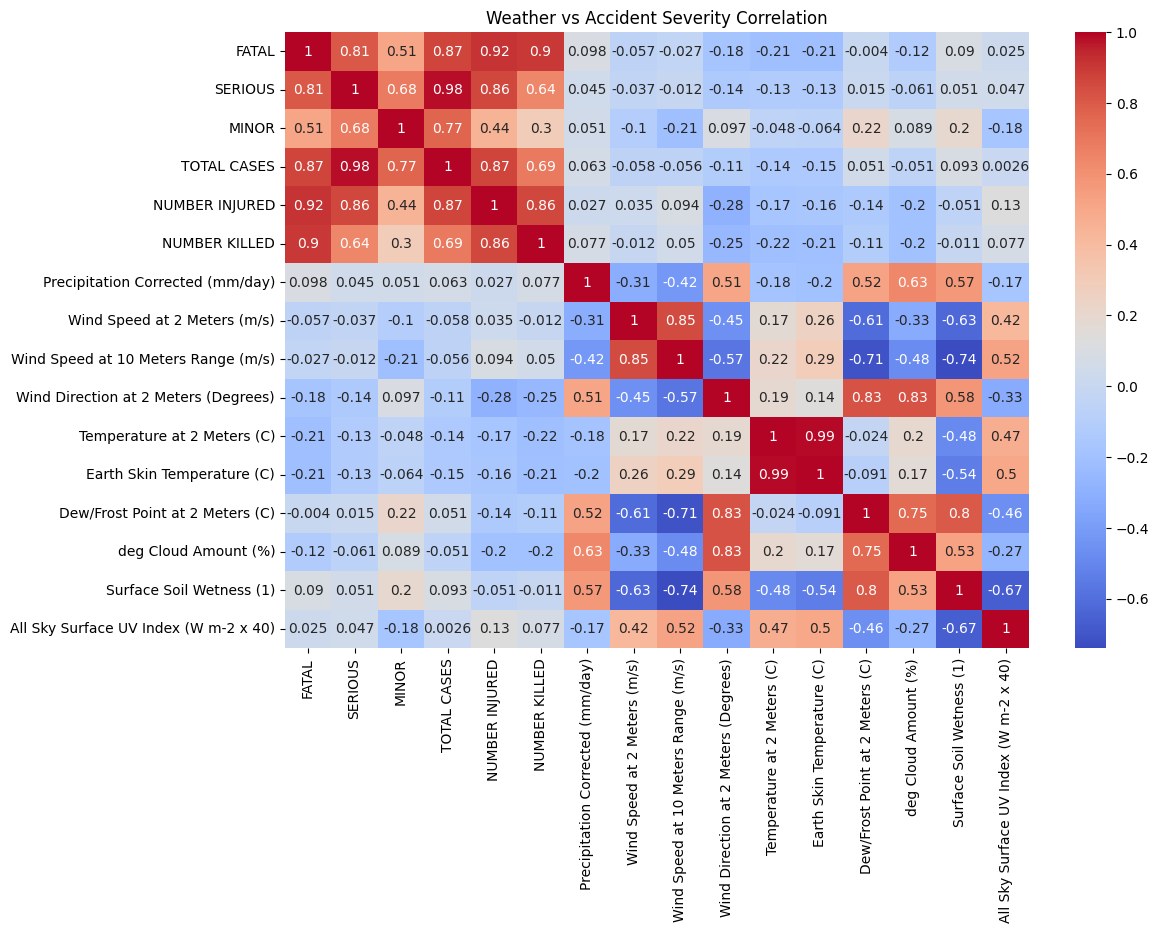

In [ ]:
weather_severity_cols = [
    'FATAL','SERIOUS','MINOR','TOTAL CASES','NUMBER INJURED','NUMBER KILLED',
    'Precipitation Corrected (mm/day)','Wind Speed at 2 Meters (m/s)','Wind Speed at 10 Meters Range (m/s)',
    'Wind Direction at 2 Meters (Degrees)','Temperature at 2 Meters (C)','Earth Skin Temperature (C)',
    'Dew/Frost Point at 2 Meters (C)','deg Cloud Amount (%)',
    'Surface Soil Wetness (1)','All Sky Surface UV Index (W m-2 x 40)'
]

plt.figure(figsize=(12,8))
sns.heatmap(weather_accidents_df[weather_severity_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Weather vs Accident Severity Correlation")
plt.show()

### INSIGHTS


The analysis of the heatmap reveals how different weather conditions influence accident severity across Nigerian states.

1. Accident Severity Metrics Move Together
Fatalities, serious injuries, minor injuries, total injured, and total cases all show very strong positive correlations (0.8–1.0). This indicates that when accident frequency rises, severity tends to rise as well—more accidents often mean more serious outcomes.

2. Temperature and Heat Stress Influence Severity
Air temperature, surface temperature, and dew point show moderate correlations (≈0.2–0.3) with accident metrics. Higher temperatures may contribute to:

    - Mechanical issues (overheating, tyre blowouts)

    - Driver fatigue and dehydration

    - Increased travel activity

    This suggests that thermal stress indirectly raises accident severity.

3. Wind Patterns Reduce Accident Risk
Wind speed (especially WS10M_RANGE) is negatively correlated (up to -0.7) with accident indicators. Stronger winds appear protective by:

    - Discouraging travel

    - Slowing drivers due to debris or stormy conditions

    Conversely, calm conditions encourage higher-speed travel, raising accident frequency and severity.

4. Cloud Cover, UV Index, and Rainfall Have Moderate or Mixed Effects
Cloudiness and UV index moderately correlate with thermal and humidity variables but only weakly with accidents. Rainfall shows minimal correlation, likely because heavy rain reduces travel, lowering accident numbers despite potential road hazards.

5. Soil Wetness Has Minimal Impact
Off-road soil moisture (GWETTOP) has negligible correlation with major road accidents, suggesting limited influence outside rural terrain.

### Key Patterns and Risk Profiles

- High-risk scenarios: Hot, dry, calm, and clear weather → increased speeding, fatigue, and severe crashes.

- Protective scenarios: High wind, rainy, or heavily cloudy conditions → drivers slow down or postpone trips, reducing accidents.

### Underlying Drivers

- Environmental: Heat stress and dry roads increase driver errors and vehicle faults. Good weather encourages higher speeds.

- Behavioral: Risk-taking, fatigue, and dangerous overtaking are more likely under favorable travel conditions.

### Conclusion
The heatmap highlights the interplay between environmental conditions and human behavior in shaping accident severity. Extreme heat, calm winds, and dry, clear weather consistently elevate accident risk, while adverse conditions, wind, rain, or cloud cover tend to suppress travel and reduce crash frequency. These insights can guide targeted safety interventions and predictive modeling.

In [ ]:
import plotly.express as px

fig = px.scatter(
    weather_accidents_df,
    x="Precipitation Corrected (mm/day)", y="TOTAL CASES",
    color="STATE",
    size="FATAL",
    hover_data=["STATE","YEAR","QUARTER"],
    title="Precipitation vs Total Accidents"
)
fig.show()




## Precipitation vs. Total Accidents Scatter Plot

### Key Insights and Patterns

- Weak Correlation: Generally, there doesn't appear to be a strong, direct, linear correlation between the amount of precipitation corrected (mm/day) and the total number of accidents. The cluster of data points is mostly concentrated in the lower precipitation range (0 to 15 mm/day).

- High Accident Volume at Low Precipitation: The bulk of the total accident cases (up to 500 or more) occurs when the "Precipitation Corrected" value is very low, near 0-10 mm/day. This suggests that most accidents happen during periods with little to moderate "corrected" rain.

- Outliers in High Precipitation: There are a few interesting outliers in the higher precipitation ranges (e.g., between 20 and 40+ mm/day) that still register a significant number of accidents (over 100 cases). For example, the point near 40 mm/day precipitation (likely FCT, based on the legend color) still has a moderate number of accidents (around 200).

- State-Specific Variations: The size and color of the bubbles highlight that certain states consistently contribute the highest number of overall accident cases, irrespective of the precipitation shown on the x-axis.

**Contributing Factors**

- Human Factors over Weather: The fact that the highest accident volumes occur in low-precipitation conditions suggests that non-weather-related factors are the primary drivers for the majority of accidents. These include:

- Driver behavior (speeding, distracted driving).

- Road infrastructure/quality.

- Traffic volume/congestion.

Severity vs. Frequency: The plot focuses on Total Cases. While heavy rain may cause more severe accidents or impact specific types of accidents (like flash floods or reduced visibility), the data indicates that the sheer frequency of all accidents is highest when precipitation is low.

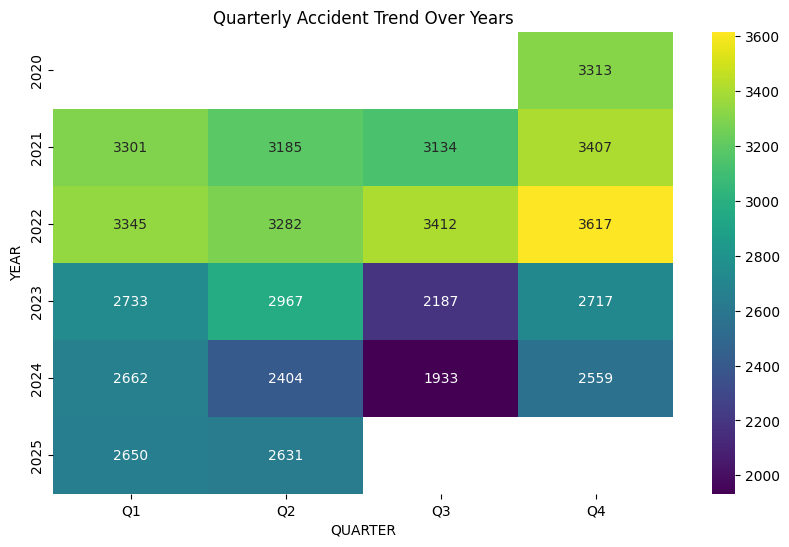

In [ ]:

pivot = weather_accidents_df.pivot_table(values='TOTAL CASES', index='YEAR', columns='QUARTER', aggfunc='sum')
plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, cmap='viridis', fmt='g')
plt.title("Quarterly Accident Trend Over Years")
plt.show()


### Quarterly Accident Trend Over Years Heatmap

#### Key Insights and Patterns

- Year-to-Year Decline: There's a noticeable overall downward trend in the total number of accidents from a high point in 2020/2021/2022 towards a significant low point in 2024 and 2025.

- The highest quarterly accident counts are consistently found in 2021 and 2022, especially Q4 (peaking at 3,617 in 2022 Q4).

- The lowest counts are observed in 2024 and the available quarters of 2025, with the lowest point being 1,933 in 2024 Q3.

### Quarterly Seasonality

- Q4 (October-December) generally records the highest number of accidents across all full years (2020-2023). This is visually represented by the brighter yellow colors in the Q4 column. This often correlates with the peak holiday travel season (Christmas and New Year).

- Q3 Dip: Q3 (July-September) tends to show a relative dip in accidents compared to Q4, especially in the later years (2023: 2,187; 2024: 1,933). This may coincide with the heart of the rainy season, where cautious driving or reduced travel might be observed.

- Unusual 2023 Dip: The year 2023 shows a very sharp drop in accident figures across all quarters compared to the preceding years, especially Q3 (2,187) and Q4 (2,717).

**Contributing Factors**

The most striking pattern is the significant and sudden drop in accident figures starting in 2023, which is a likely reflection of the aftermath of the fuel subsidy removal.

The removal of the fuel subsidy in May 2023 led to an immediate and substantial increase in the price of petrol, which serves as a major driver for the observed decline in accident figures.

- Reduced Road Traffic Volume: The primary effect of the price hike was the increased cost of transportation. This economic pressure likely led to:

  - Less frequent travel for non-essential purposes.

  - A shift from personal vehicles to public transportation (though public transport costs also rose).

  - Lower utilization of commercial vehicles (taxis, haulage) due to higher operating costs.

  - Fewer vehicles on the road overall, directly reducing the statistical probability of accidents.

- Behavioral Change/Cost Consciousness: Higher fuel prices incentivize drivers to be more fuel-efficient. This often translates into slower speeds, less aggressive driving, and better trip planning—all behaviors that naturally contribute to fewer accidents.

- Sustained Impact into 2024: The low figures in 2024 (especially the record low of 1,933 in Q3) suggest that the economic adjustments caused by the subsidy removal—and the resulting change in travel habits—have been sustained and potentially even amplified.

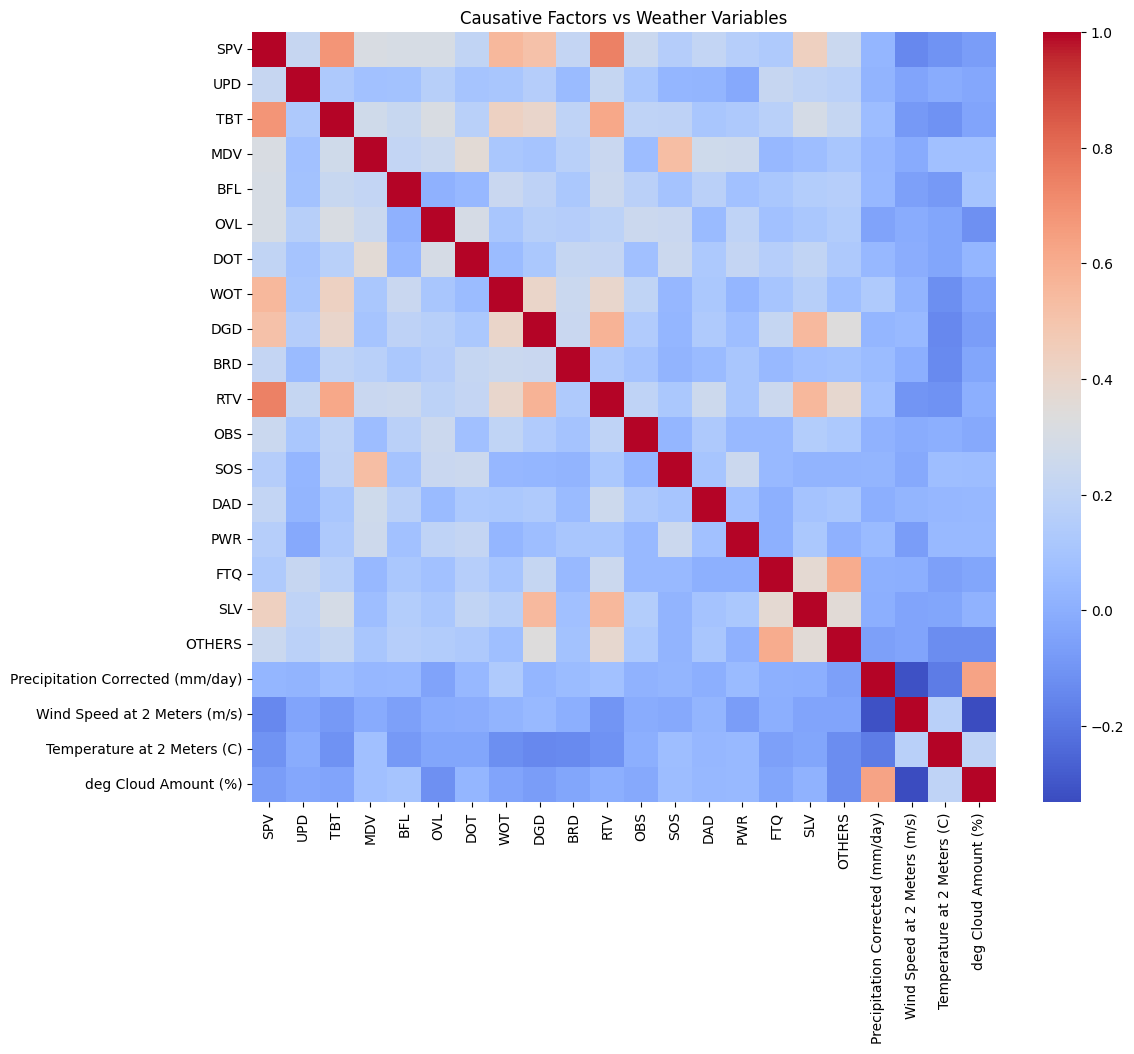

In [ ]:
cause_cols = ['SPV', 'UPD',	'TBT',	'MDV',	'BFL',	'OVL',
              'DOT',	'WOT',	'DGD',	'BRD',	'RTV',
              'OBS',	'SOS',	'DAD',	'PWR',	'FTQ',	'SLV',	'OTHERS']

cause_weather_corr = weather_accidents_df[cause_cols + [
    'Precipitation Corrected (mm/day)','Wind Speed at 2 Meters (m/s)','Temperature at 2 Meters (C)','deg Cloud Amount (%)'
]].corr()

plt.figure(figsize=(12,10))
sns.heatmap(cause_weather_corr, cmap="coolwarm")
plt.title("Causative Factors vs Weather Variables")
plt.show()

# weather_accidents_df.sample()


## INSIGHTS

1. Precipitation's Relationships (The "Rain" Column)
Look at the column for "Precipitation Corrected (mm/day)".

  - Positive Correlation (Red): Precipitation shows a weak-to-moderate positive link with several causative factors. This suggests that as rain increases, certain types of incidents become slightly more frequent. While the codes need definition, common sense suggests these positively correlated factors might relate to:

    - Reduced Visibility (OBS/DAD): Rain naturally makes it harder to see.

    - Loss of Control (SLV/BFL): Wet roads lead to skidding.

**Key Insight**

This supports the previous scatter plot—rain is a risk multiplier. It doesn't cause the majority of accidents, but it increases the likelihood of specific events (like skidding or poor visibility) when it occurs.

2. Temperature's Relationships (The "Heat" Column)
Look at the column for "Temperature at 2 Meters (C)".

- Negative Correlation (Blue): Temperature shows a clear, moderate negative correlation with many of the causative factors (especially those related to human error like SPV/UPD).

    **Interpretation**
    - This is highly significant. It implies that as the temperature rises, the frequency of many causative factors tends to decrease. This seems counter-intuitive, as we often associate heat with driver fatigue.

- Possible Explanation: This might be a seasonal artifact. High temperatures often coincide with the dry season, which is also when the most frequent accidents (driven by speed, congestion, and non-weather causes) occur (as seen in the scatter plot). If high temperatures happen during months where overall traffic is lower or more cautious, it might show a negative correlation with these factors. Alternatively, the correlation is simply weak enough that no strong conclusion can be drawn without more context.

3. Wind and Cloud Amount

- Wind Speed: Shows a weak, mixed correlation. It is a minor factor overall.

- Cloud Amount: Shows a moderate negative correlation (blue) with some key causative factors.

    - **Interpretation**

      This also aligns with seasonality. High cloud cover (heavy cloud) is typical of the rainy season, which, as noted by the Heatmap, sees an overall drop in accident numbers (Q3). Therefore, high cloud cover is correlated with a period of lower total accidents.

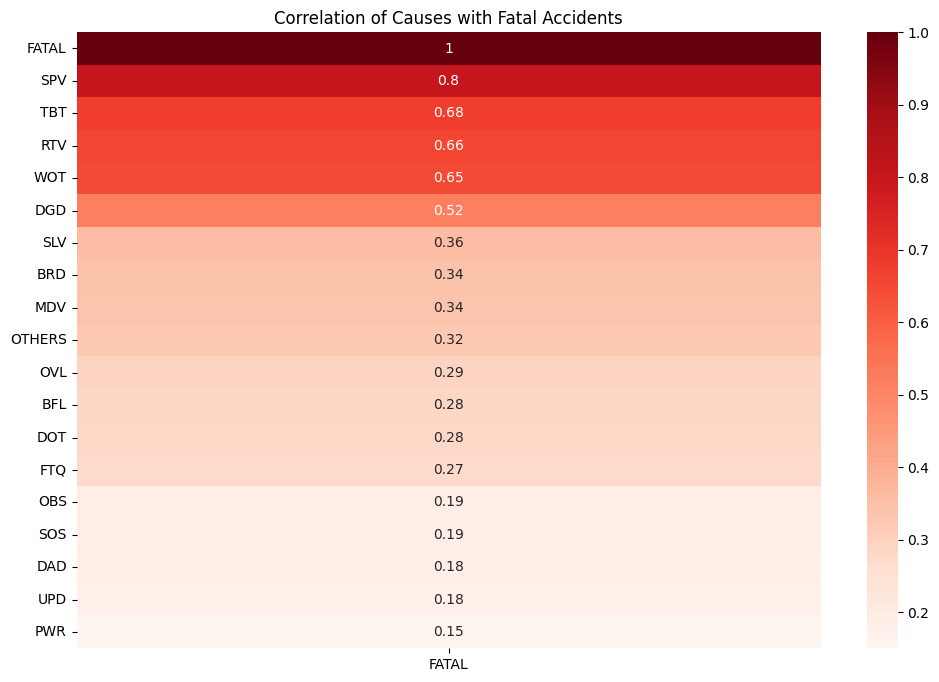

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

cause_cols = ['SPV','UPD','TBT','MDV','BFL','OVL','DOT','WOT','DGD','BRD','RTV','OBS','SOS','DAD','PWR','FTQ','SLV','OTHERS']

plt.figure(figsize=(12,8))
sns.heatmap(weather_accidents_df[cause_cols + ['FATAL']].corr()['FATAL'].sort_values(ascending=False).to_frame(), annot=True, cmap='Reds')
plt.title("Correlation of Causes with Fatal Accidents")
plt.show()


Analysis of Factors Contributing to Fatal Accidents

An examination of the relationship between different accident causes and fatal outcomes reveals clear patterns in risk attribution. Correlation analysis was conducted between each causative factor and the number of fatalities recorded. The findings provide insight into which factors are most strongly associated with fatal accidents, offering a basis for prioritizing safety interventions and policy measures.

Key Insights:

Driver-related issues dominate fatal outcomes.

  - The factor SPV (speeding) shows the strongest correlation with fatalities at
0.80, indicating that driver actions are the leading contributor to fatal accidents.

  - Other driver-related factors such as WOT (wrong overtaking) and DGD (dangerous driving) also show strong correlations of 0.65 and 0.52, respectively.

This clearly highlights the critical need for stricter enforcement of driving rules and driver awareness campaigns.

Vehicle and road conditions are significant contributors.

- TBT (Tyre Bursts) and RTV (route violations) show correlations of 0.68 and 0.66, respectively.

These findings indicate that while driver behavior is the primary cause, mechanical issues and road infrastructure also play a substantial role in fatalities.

Moderate correlations for other causes.

- Factors such as SLV (Sign light violations), BRD (Bad roads), and MDV (mechanical deficient vehicle) have correlations in the range of 0.34–0.36, suggesting they contribute but are less dominant than driver-related factors.

Low correlation causes are less impactful.

Environmental factors like OBS (road obstruction violations), PWR (poor weather), and DAD (driving under alcohol/drug influence) have correlations below 0.20, indicating they are relatively minor contributors to fatalities compared to human and vehicle factors.

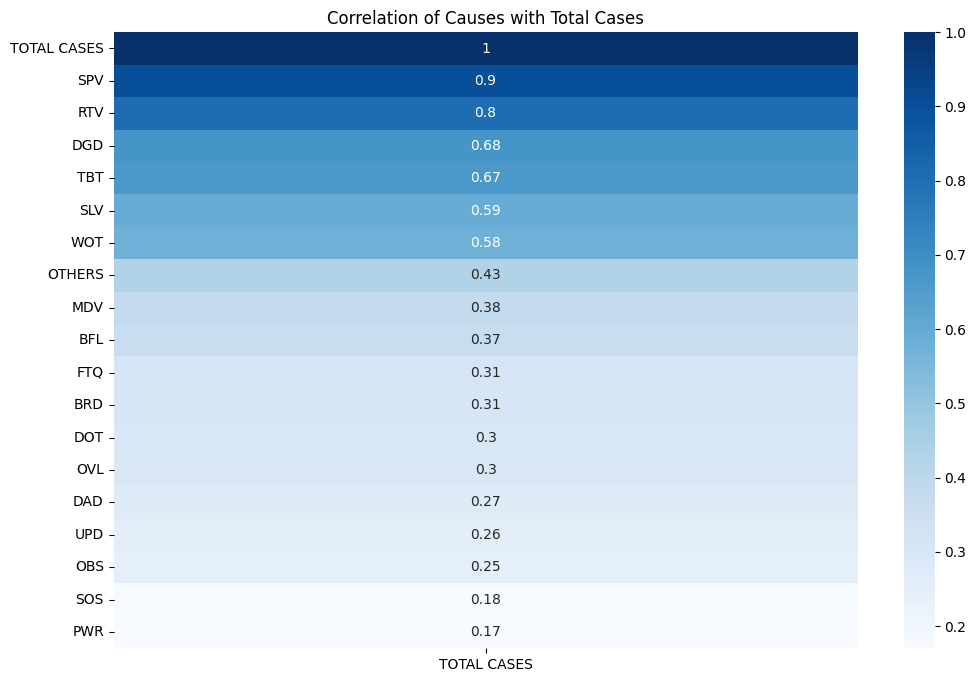

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

cause_cols = ['SPV','UPD','TBT','MDV','BFL','OVL','DOT','WOT','DGD','BRD','RTV','OBS','SOS','DAD','PWR','FTQ','SLV','OTHERS']

plt.figure(figsize=(12,8))
sns.heatmap(weather_accidents_df[cause_cols + ['TOTAL CASES']].corr()['TOTAL CASES'].sort_values(ascending=False).to_frame(), annot=True, cmap='Blues')
plt.title("Correlation of Causes with Total Cases")
plt.show()


Driver-related factors dominate accident occurrences

  - SPV has the highest correlation with total cases at 0.90, indicating that driver behavior is the single most influential factor in accident frequency.

  - Other driver-related factors, such as DGD and WOT, also show moderate correlations between 0.57–0.68, reinforcing the need for interventions targeting driver behavior.

Infrastructure and road conditions are significant

  - RTV and SLV correlate with total cases at 0.80 and 0.59, respectively. This highlights the importance of improving road safety measures and maintenance.

Mechanical and vehicle factors have moderate impact

  - Factors like TBT and MDV have correlations around 0.66 and 0.38, showing that while mechanical problems contribute, they are less critical than human and road factors.

Environmental and miscellaneous factors are less influential

  - OBS, PWR, and SOS have correlations below 0.25, suggesting that environmental conditions or other rare causes play a smaller role in the total number of accidents.

  - OTHERS is moderately correlated at 0.43, indicating some residual factors not captured by the main categories.

# EXPLORATION SUMMARY

### Analysis of Road Accident Data and Key Contributing Factors in Nigeria

This report summarizes an extensive exploration of road accident data in Nigeria, highlighting the primary factors influencing accident frequency and severity. The analysis covers driver behavior, vehicle and road conditions, environmental influences, and temporal trends, providing insights for targeted interventions and predictive modeling.

#### Key Findings
1. Driver Behavior Dominates Accident Occurrences

    - Driver-related factors are the most significant contributors to accidents. Specifically:

    - Speeding (SPV) exhibits the strongest correlation with total accidents (0.90) and fatalities (0.80), establishing it as the single most influential factor.

    - Other critical behaviors, including dangerous driving (DGD) and wrong overtaking (WOT), show moderate to strong correlations (0.52–0.68) with accidents and fatalities.

Implication: Interventions targeting driver behavior—such as awareness campaigns, stricter enforcement of traffic rules, and speed control measures—are essential for accident reduction.

2. Road Infrastructure and Vehicle Factors

    - While driver behavior leads, road and vehicle conditions also significantly affect accident outcomes:

    - Route violations (RTV) and sign light violations (SLV) correlate moderately with total accidents (0.80 and 0.59, respectively) and fatalities (0.66 and 0.34).

    - Mechanical issues, including tyre bursts (TBT) and mechanically deficient vehicles (MDV), have moderate but lower correlations (0.38–0.68).

Implication: Upgrading road infrastructure, improving signage, and promoting regular vehicle maintenance can mitigate both accident frequency and severity.

3. Environmental and Miscellaneous Factors

Environmental conditions and other minor factors have limited influence:

    - Factors such as poor weather (PWR), road obstructions (OBS), and alcohol/drug-related driving (DAD) show weak correlations (<0.25) with accidents and fatalities.

    - Precipitation demonstrates a weak-to-moderate positive effect on specific accident types (reduced visibility), but most accidents occur under low-rain conditions.

    - Temperature exhibits a moderate negative correlation with human-error-related accidents, likely reflecting seasonal traffic patterns rather than a direct causal relationship.

Implication: Environmental factors act more as risk multipliers rather than primary causes; interventions should focus on human and infrastructural factors while accounting for weather effects.

4. Temporal Patterns and Policy Impacts

    - Quarterly trends reveal a peak in accidents during Q4 (holiday season) and a dip in Q3 (rainy season), indicating seasonal travel and behavior patterns.

    - A pronounced drop in accidents from 2023 onward correlates with the removal of the fuel subsidy, which increased fuel costs, reduced traffic volumes, and encouraged more cautious driving.

    - Accident severity tends to rise alongside frequency; higher temperatures and calm, dry conditions increase accident risk, whereas rain, cloud cover, or strong winds reduce accidents by discouraging travel or promoting slower driving.

Implication: Economic and seasonal factors substantially influence travel behavior and accident risk. Predictive models should incorporate these temporal and policy-driven variables.

### Environmental Effects on Accident Modeling

The exploration highlighted several nuanced environmental effects relevant for modeling:

  - Rainfall: Increases specific risks like skidding and visibility issues but does not drive overall accident frequency.

  - Temperature and heat: Higher temperatures slightly increase risk through fatigue and mechanical failures but show negative correlation with frequency due to seasonal patterns.

  - Wind and cloud cover: High wind speeds and heavy clouds reduce travel and lower accident occurrence.

Modeling Insight: Including driver behavior, road conditions, and economic/seasonal variables will improve model accuracy. Environmental factors act more as modifiers than primary predictors.

## Conclusion

The analysis confirms that driver behavior is the primary determinant of accidents and fatalities, with road infrastructure and vehicle conditions playing secondary roles. Environmental conditions influence behavior and severity indirectly. Temporal patterns and economic factors, such as fuel price changes, significantly affect traffic volume and accident risk.

For policymakers, these findings emphasize:

  - Focused driver safety interventions.

  - Continued investment in road infrastructure and vehicle safety.

  - Incorporation of seasonal and economic factors in predictive models to anticipate accident trends.

This comprehensive insight serves as a foundation for targeted prevention strategies and data-driven traffic safety policies in Nigeria.

# DATA PREPROCESSING

In [ ]:
weather_accidents_df.sample()

,STATE,FATAL,SERIOUS,MINOR,TOTAL CASES,NUMBER INJURED,NUMBER KILLED,TOTAL CASUALTY,PEOPLE INVOLVED,SPV,UPD,TBT,MDV,BFL,OVL,DOT,WOT,DGD,BRD,RTV,OBS,SOS,DAD,PWR,FTQ,SLV,OTHERS,QUARTER,YEAR,All Sky Surface Total PAR (MJ/m^2/day),All Sky Surface UV Index (W m-2 x 40),deg Cloud Amount (%),Surface Soil Wetness (1),Precipitation Corrected (mm/day),Surface Pressure (kPa),Specific Humidity at 2 Meters (g/kg),Temperature at 2 Meters (C),Dew/Frost Point at 2 Meters (C),Earth Skin Temperature (C),Wind Direction at 2 Meters (Degrees),Wind Speed at 10 Meters Range (m/s),Wind Speed at 2 Meters (m/s)
615,KWARA,17,33,4,54,233,56,289,507,52,0,6,5,1,0,0,7,0,0,0,1,0,0,0,0,0,4,Q4,2024,8.983333,1.77,35.273333,0.573333,2.036667,97.813333,12.756667,25.02,16.713333,25.246667,79.733333,2.676667,1.68


In [ ]:
accidents_causative_factors

,CAUSATIVE FACTORS,CODE
0,Speed Violation (SPV),SPV
1,Use of Phone While Driving (UPWD),UPWD
2,Tyre Burst (TBT),TBT
3,Mechanically Deficient Vehicle (MDV),MDV
4,Brake Failure (BFL),BFL
5,Overloading (OVL),OVL
6,Dangerous Overtaking (DOT),DOT
7,Wrongful Overtaking (WOT),WOT
8,Dangerous Driving (DGD),DGD
9,Bad Road (BRD),BRD


In [ ]:
def extract_risk_lvl_and_causative_factors_grouping(df):

    """
      Computes accident risk metrics and groups causative factors into broader categories.

      This function performs the following steps on a road accident dataset:

      1. Calculate Cause Rate and Risk Level:
        - Computes `CAUSE_SUM` by summing the accident metrics: ['FATAL', 'SERIOUS', 'MINOR', 'NUMBER INJURED', 'NUMBER KILLED'].
        - Calculates `CAUSE_RATE` as the proportion of total cases (`TOTAL CASES`) attributable to the summed metrics.
        - Assigns `RISK_LEVEL` based on quantiles of the ranked `CAUSE_RATE` values. Labels: 'LOW', 'HIGH'.

      2. Group Causative Factors:
        - Aggregates detailed causative factor columns into broader groups:
          - `DRIVER`: Human/driver factors ( SPV, OVL, DOT, WOT, DGD, SOS, DAD )
          - `MECHANICAL`: Vehicle mechanical issues ( BFL, MDV, TBT, BRD )
          - `ENVIRONMENT`: Environmental or weather conditions ( OBS, PWR, FTQ )
          - `ROAD`: Road infrastructure or conditions ( RTV, SLV )
          - `VEHICLE`: Vehicle type or condition influence ( UPD, TBT )
          - `OTHERS`: Miscellaneous factors ( OTHERS )
        - Each group is summed per row and normalized by `TOTAL CASES`.

      3. Data Cleaning:
        - Drops unnecessary columns: `cause_cols`, first 6 `weather_severity_cols`, 'TOTAL CASUALTY', and 'PEOPLE INVOLVED'.
        - Fills any remaining missing values with the column mean.
    """
    # Compute cause rate & risk level

    accident_metrics = ["FATAL", "SERIOUS", "MINOR", "NUMBER INJURED", "NUMBER KILLED"]
    df['CAUSE_SUM'] = df[accident_metrics].sum(axis=1)
    df['CAUSE_RATE'] = df['CAUSE_SUM'] / df['TOTAL CASES'].replace(0, pd.NA)
    df['CAUSE_RATE'] = df['CAUSE_RATE'].fillna(0)
    df = df.drop("CAUSE_SUM", axis=1)

    df['RISK_LEVEL'] = pd.qcut(df['CAUSE_RATE'].rank(method='first'),
                           q=2, labels=['LOW', 'HIGH'])


    # Group causative factors
    driver_factors = ['SPV','OVL','DOT','WOT','DGD','SOS','DAD', 'FTQ', 'UPD'] # UPD  # Human/driver factors
    mechanical_factors = ['BFL','MDV','TBT']                       # Mechanical/vehicle issues
    environmental_factors = ['PWR']                           # Environmental/conditions
    road_factors = ['RTV','SLV', 'BRD', 'OBS']                                          # Road infrastructure
    other_factors = ["OTHERS"]

    # Sum each group per row
    df['DRIVER'] = df[driver_factors].sum(axis=1)
    df['MECHANICAL'] = df[mechanical_factors].sum(axis=1)
    df['ENVIRONMENT'] = df[environmental_factors].sum(axis=1)
    df['ROAD'] = df[road_factors].sum(axis=1)
    df['OTHERS'] = df[other_factors].sum(axis=1)

    # Normalize by TOTAL_CASES
    group_cols = ['DRIVER','MECHANICAL','ENVIRONMENT','ROAD']
    df[group_cols] = df[group_cols].div(df['TOTAL CASES'].replace(0, pd.NA), axis=0).fillna(0)

    df = df.drop(cause_cols, axis=1).drop(weather_severity_cols[:6] + ['TOTAL CASUALTY',	'PEOPLE INVOLVED'], axis=1)

    for col in df:
        if df[col].isna().sum() > 0:
            df[col] = df[col].fillna(df[col].mean())


    return df


In [ ]:
accidents_causative_factors

,CAUSATIVE FACTORS,CODE
0,Speed Violation (SPV),SPV
1,Use of Phone While Driving (UPWD),UPWD
2,Tyre Burst (TBT),TBT
3,Mechanically Deficient Vehicle (MDV),MDV
4,Brake Failure (BFL),BFL
5,Overloading (OVL),OVL
6,Dangerous Overtaking (DOT),DOT
7,Wrongful Overtaking (WOT),WOT
8,Dangerous Driving (DGD),DGD
9,Bad Road (BRD),BRD


The dataset underwent a structured process to generate insights about accident severity and the contributing factors, with the goal of identifying high-risk areas and understanding the drivers of accidents.

1. Measuring Accident Severity

    The first step involved quantifying the overall severity of accidents. This was done by combining multiple metrics of accident outcomes, including the number of fatal, serious, and minor accidents, as well as the total number of people injured or killed. By aggregating these measures, we derived a single cause intensity score for each record, representing the overall impact of accidents relative to their frequency.

  This step allows decision-makers to go beyond simple counts of accidents and understand which areas or situations are particularly severe, thereby highlighting priority areas for intervention.

2. Establishing Risk Levels

    Based on the severity score, a risk level was assigned to each record. Records were categorized into LOW or HIGH risk depending on how severe the accidents were relative to all other records.

    - High-risk records indicate areas or situations where accidents are more severe and could result in significant human and economic costs.

    - Low-risk records indicate less severe outcomes, suggesting that while accidents occur, their impact is comparatively lower.

This segmentation is critical for businesses and regulatory agencies, as it enables targeted allocation of resources, enforcement, and preventive measures in areas with the greatest potential for harm.

3. Grouping and Assessing Contributing Factors

To understand why accidents occur, individual causative factors were grouped into broader categories. This analytical grouping allows stakeholders to see patterns rather than being lost in individual codes or isolated incidents. The main categories were:

    Driver-related factors: Human behaviors such as speeding, distracted driving, or poor decision-making.

    Mechanical issues: Failures in vehicle components, such as brakes or tires.

    Environmental conditions: Weather and other external factors that may increase accident likelihood.

    Road infrastructure: Issues related to the road itself, like poor maintenance or design flaws.

    Other factors: Miscellaneous or unclassified contributors.

Each category was measured as a proportion of total accidents, giving insight into which factors are most responsible for risk in different contexts. This helps businesses or policy-makers prioritize interventions—for instance, focusing on driver training programs if human factors dominate, or investing in road maintenance if infrastructure-related factors are significant.

Finally, any missing values were addressed by using average values, ensuring the dataset is complete and reliable for analysis. Unnecessary columns were removed to streamline the dataset and focus on actionable insights.

In [ ]:
updated_weather_data = extract_risk_lvl_and_causative_factors_grouping(weather_accidents_df)
updated_weather_data.sample()

,STATE,QUARTER,YEAR,All Sky Surface Total PAR (MJ/m^2/day),All Sky Surface UV Index (W m-2 x 40),deg Cloud Amount (%),Surface Soil Wetness (1),Precipitation Corrected (mm/day),Surface Pressure (kPa),Specific Humidity at 2 Meters (g/kg),Temperature at 2 Meters (C),Dew/Frost Point at 2 Meters (C),Earth Skin Temperature (C),Wind Direction at 2 Meters (Degrees),Wind Speed at 10 Meters Range (m/s),Wind Speed at 2 Meters (m/s),CAUSE_RATE,RISK_LEVEL,DRIVER,MECHANICAL,ENVIRONMENT,ROAD
659,OYO,Q1,2025,8.193333,1.59,52.87,0.623333,1.286667,97.763333,16.056667,26.156667,20.76,26.39,165.766667,2.69,1.656667,4.245033,LOW,1.350993,0.198675,0.0,0.125828


In [ ]:
def preprocess_accident_data(df):
    """
      Preprocesses the road accident dataset for model training.

      Steps performed:
      1. Defines relevant feature groups:
          - Causative factor groups: DRIVER, MECHANICAL, ENVIRONMENT, ROAD, VEHICLE
          - Weather features: Cloud amount, soil wetness, precipitation, pressure, humidity,
            dew point, earth temperature, wind direction, wind speed
          - Temporal features: YEAR, QUARTER
          - Categorical features: QUARTER
      2. Encodes the target column 'RISK_LEVEL' to numeric values: LOW=0, HIGH=1
      3. Converts QUARTER (e.g.,'Q1') and YEAR to numeric types
      4. Fills missing numeric values with the median per column
      5. Performs target encoding on STATE using the target variable and saves the encoder
      6. Prepares the final feature set `X` including encoded STATE
      7. Scales all features using StandardScaler and saves the scaler
    """
    df = df.copy()

    # 1. Define columns
    grouped_cause_cols = ['DRIVER','MECHANICAL','ENVIRONMENT','ROAD']
    weather_cols = [
        'deg Cloud Amount (%)',
        'Surface Soil Wetness (1)',
        'Precipitation Corrected (mm/day)',
        'Surface Pressure (kPa)',
        'Specific Humidity at 2 Meters (g/kg)',
        'Dew/Frost Point at 2 Meters (C)',
        'Earth Skin Temperature (C)',
        'Wind Direction at 2 Meters (Degrees)',
        'Wind Speed at 2 Meters (m/s)'
    ]
    temporal_cols = ['YEAR']
    categorical_quarter = ['QUARTER']

    # 2. Encode target
    y = df['RISK_LEVEL'].map({'LOW':0,'HIGH':1})

    # 3. QUARTER & YEAR numeric
    df['QUARTER'] = df['QUARTER'].str.replace('Q','').astype(int)
    df['YEAR'] = pd.to_numeric(df['YEAR'], errors='coerce')

    # 4. Fill missing numeric values
    all_numeric_cols = grouped_cause_cols + weather_cols + temporal_cols + categorical_quarter
    for col in all_numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col].fillna(df[col].median())

    # 6. Prepare final X
    X = df[grouped_cause_cols + weather_cols + temporal_cols + categorical_quarter + ['STATE']].copy()


    return X, y

X, y = preprocess_accident_data(updated_weather_data)

1. Grouping the Features

Before any modelling begins, the function groups the key variables into categories like causative factors, weather conditions, and temporal details. Sounds simple, right? Yet, when you think about it, DRIVER, MECHANICAL, ENVIRONMENT, and ROAD factors are the same issues we complain about daily — the reckless danfo driver swerving across lanes, or that poorly maintained truck climbing a hill with one headlamp. Weather features such as humidity or soil wetness also reflect days when rain turns Nigerian roads into skating rinks.

Organising these features is not just technical neatness; it helps paint a structured picture of why accidents happen.

2. Encoding the Target Variable

RISK_LEVEL is transformed from LOW and HIGH into 0 and 1. I won’t lie—sometimes reducing real danger into binary digits feels strange. But machine-learning models need it, so LOW becomes 0 and HIGH becomes 1. Behind that “1” might be a fatal accident on Sagamu Road that caused a traffic jam for hours. Still… we encode it because that’s how the algorithms understand risk.

3. Cleaning Temporal Fields

QUARTER values like "Q1" are stripped to become plain integers. YEAR is carefully converted into numeric form as well. These small changes reduce confusion later on. What’s funny is how many datasets from Nigerian agencies mix formats, sometimes YEAR comes in as text, other times as numbers with trailing spaces, occasionally both. You just have to sigh and clean it up.

4. Handling Missing & Messy Values

Every numeric column is checked for odd entries, wrong types, or blanks. And honestly, working with datasets from Nigerian sources can be a battle. Missing values? Plenty. Wrong formats? Very common. S

To keep the model steady, all missing numeric values are filled with the column median. Some might debate this choice — “Why median? Why not mean or an imputation model?” My take? With skewed accident data, median feels like the safest middle ground. Still, no approach is perfect.

5. Assembling the Final Feature Matrix

After all the cleaning, the function gathers the key variables — weather, causative factors, time, and the STATE field — into one feature matrix. STATE is kept as is (for now), because depending on the final modelling strategy, you might encode it differently later.

Whenever I look at the STATE variable, I remember how accident patterns differ across Nigeria. For instance:

  - Rivers State sees a lot more rain-related cases.

  - Kano tends to have more mechanical faults because of long-haul cargo movements.

  - Lagos? A mix of everything — congestion, aggressive driving, road rage, you name it.

So, including STATE is important for capturing these regional patterns.

In [ ]:
from imblearn.over_sampling import SMOTE


def fit_predict(model, params, X, y, K, smote=True):
    import warnings
    warnings.filterwarnings("ignore")

    """
      Train, tune, and evaluate a machine learning model using K-Fold cross-validation,
      optional SMOTE oversampling, and hyperparameter optimization.

      This function performs:
          1. K-Fold splitting of the dataset
          2. SMOTE oversampling on the training split (optional), and standard scaling
          3. Hyperparameter tuning using GridSearchCV
          4. Model training on each fold
          5. Evaluation of performance on both train and test sets
          6. Aggregated reporting of accuracy, precision, and recall across folds

    """
    global results

    kfold = KFold(n_splits=K, shuffle=True, random_state=2)
    results = []

    for i, (train_index, test_index) in enumerate(kfold.split(X, y)):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]


        # Encode STATE on TRAIN ONLY
        te = TargetEncoder(smoothing=15)
        X_train['STATE_TE'] = te.fit_transform(X_train[['STATE']], y_train)
        X_test['STATE_TE'] = te.transform(X_test[['STATE']])

        # Remove raw STATE column
        X_train = X_train.drop(columns=['STATE'])
        X_test = X_test.drop(columns=['STATE'])

        # 7. Scale features
        scaler = StandardScaler()
        X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
        X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])


        # Handle class imbalance with SMOTE
        if smote:
            sm = SMOTE(random_state=42)
            X_train, y_train = sm.fit_resample(X_train, y_train)

        # GRIDSEARCH
        clf = GridSearchCV(model, param_grid=params, cv=2)
        clf.fit(X_train, y_train)

        # Predictions
        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)

        # Train metrics
        acc_train = accuracy_score(y_train, y_train_pred)
        recall_train = recall_score(y_train, y_train_pred, average='weighted')
        prec_train = precision_score(y_train, y_train_pred, average='weighted')

        # Test metrics
        acc_test = accuracy_score(y_test, y_test_pred)
        recall_test = recall_score(y_test, y_test_pred, average='weighted')
        prec_test = precision_score(y_test, y_test_pred, average='weighted')

        # Append results to global list
        results.append({
            "Model": model.__class__.__name__,
            "Train Accuracy": round(acc_train, 3),
            "Test Accuracy": round(acc_test, 3),
            "Train Precision": round(prec_train, 3),
            "Test Precision": round(prec_test, 3),
            "Train Recall": round(recall_train, 3),
            "Test Recall": round(recall_test, 3),
        })


        results_df = pd.DataFrame(results)

    print("\n Model Comparison Table:")
    print(results_df.sort_values(by="Test Accuracy", ascending=False).to_string(index=False))
    print(f"\nModel: {model.__class__.__name__}")
    print(f"Best Params: {clf.best_params_}")
    print(f"Best CV Score: {clf.best_score_}")
    print(f"AVG Accuracy : {results_df['Test Accuracy'].mean()}")

    return clf

1. Cross-Validation

The process kicks off with K-Fold cross-validation. Instead of throwing all data at the model at once, the dataset is cut into several folds.
In each round:

  - One fold becomes the test set.

  - The rest combine into the training set.

And you repeat this until every point has been tested exactly once. It’s almost like giving every student in class a chance to answer the question — nobody is ignored.

On Nigerian datasets especially, where sample sizes can be uneven or noisy, this fairness matters. It forces the model to prove itself multiple times, not just once.

2. SMOTE Oversampling

Many real datasets, especially risk or fraud or accident severity, are seriously imbalanced. Sometimes HIGH-risk cases are so rare that the model barely sees them. SMOTE tries to fix that… but only on the training portion of each fold.

Why does that matter?

    Well, oversampling the test set would be like leaking exam answers to the student. And trust me, Nigerian accident datasets are notorious for imbalance: you might have 500 LOW-risk cases for every 10 HIGH-risk ones.

SMOTE forces the model to actually learn what makes a case dangerous, not just guess the majority.

3. GridSearchCV: Trying Out the Best Possible Model

Inside each fold, the function runs a GridSearchCV — basically letting the algorithm try different hyperparameters until it finds the combination that works best.

Honestly? Sometimes I wish life had GridSearch too — try combinations of decisions and pick the optimal one. But back to ML…

Each fold gets:

  - its own tuning process

  - its own best hyperparameters

  - its own internal validation

This means the model doesn’t get lazy and reuse parameters that only worked once.

4. Training the Optimized Model

Once the best parameters are found, the model is finally trained on the resampled data. This is where the algorithm “properly sits up” because it’s now using:

  - balanced data

  - tuned hyperparameters

It’s almost like giving the model a clean learning environment, with no noise and no shortcuts.

5. Evaluating Performance — Both Train & Test

Each fold gives back a set of metrics such as:

  - accuracy

  - precision (weighted)

  - recall (weighted)

And here’s the part I always pay attention to:

  - Training metrics show whether the model is overconfident.

  - Test metrics show whether it can handle unseen reality.

6. Aggregating and Comparing Fold Results

After all folds finish, the function collects every metric into a summary table. I like this part because it tells a story:

  - Which folds performed well?

  - Which struggled?

  - Were the best hyperparameters consistent?

  - What’s the average test accuracy?

This broader picture helps judge if the model is truly reliable or just pretending.

Sometimes, especially with messy Nigerian datasets, you might see huge variation between folds which is a signal that the data is unstable or inconsistent.

7. Returning the Final Tuned Model

At the end, the function returns the final GridSearchCV object — basically the “graduate” version of the model. It comes with:

  - the tuned estimator

  - the optimal hyperparameters

  - the best CV score it achieved

In [ ]:
logistic_regression = fit_predict(LogisticRegression(), {
                                    "C": [0.001, 0.01, 0.1, 1, 10],
                                    "solver": ["lbfgs"],
                                    "class_weight": [None, "balanced"],
                                    "max_iter": [300, 500]
                                  }, X, y, 2)




 Model Comparison Table:
             Model  Train Accuracy  Test Accuracy  Train Precision  Test Precision  Train Recall  Test Recall
LogisticRegression           0.850          0.798            0.850           0.801         0.850        0.798
LogisticRegression           0.812          0.795            0.818           0.807         0.812        0.795

Model: LogisticRegression
Best Params: {'C': 0.01, 'class_weight': None, 'max_iter': 300, 'solver': 'lbfgs'}
Best CV Score: 0.8043478260869565
AVG Accuracy : 0.7965


In [ ]:
random_forest = fit_predict(RandomForestClassifier(), {
                                      'n_estimators': [10, 20, 30],
                                      'max_depth': [None, 3, 5, 7],
                                      'min_samples_split': [2, 5, 10],
                                      'min_samples_leaf': [2, 3, 5],
                                      'bootstrap': [True, False]
                                        }, X, y, 2)




 Model Comparison Table:
                 Model  Train Accuracy  Test Accuracy  Train Precision  Test Precision  Train Recall  Test Recall
RandomForestClassifier           0.970          0.789            0.970           0.795         0.970        0.789
RandomForestClassifier           0.921          0.770            0.921           0.774         0.921        0.770

Model: RandomForestClassifier
Best Params: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 30}
Best CV Score: 0.8206521739130435
AVG Accuracy : 0.7795000000000001


In [ ]:
# XGBoost
xgb_params = {
    'n_estimators': [10, 20, 30],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

xgboost = fit_predict(XGBClassifier(eval_metric='mlogloss'),
            xgb_params, X, y, 2)




 Model Comparison Table:
        Model  Train Accuracy  Test Accuracy  Train Precision  Test Precision  Train Recall  Test Recall
XGBClassifier           0.861          0.803            0.862           0.810         0.861        0.803
XGBClassifier           0.962          0.790            0.962           0.791         0.962        0.790

Model: XGBClassifier
Best Params: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 20, 'subsample': 0.8}
Best CV Score: 0.8206521739130435
AVG Accuracy : 0.7965


In [ ]:
# Gradient Boosting
gb_params = {
    'n_estimators': [10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.7, 0.8, 1.0]
}

gradient_boosting = fit_predict(GradientBoostingClassifier(),
            gb_params, X, y, 2)

# Best CV Score: 0.8206521739130435
# AVG Accuracy : 0.794


 Model Comparison Table:
                     Model  Train Accuracy  Test Accuracy  Train Precision  Test Precision  Train Recall  Test Recall
GradientBoostingClassifier           0.856          0.798            0.859           0.806         0.856        0.798
GradientBoostingClassifier           0.883          0.793            0.883           0.794         0.883        0.793

Model: GradientBoostingClassifier
Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 30, 'subsample': 0.8}
Best CV Score: 0.8179347826086957
AVG Accuracy : 0.7955000000000001


In [ ]:
# Decision Tree
dt_params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': [None, 'sqrt', 'log2']
}

decision_tree = fit_predict(DecisionTreeClassifier(),
            dt_params, X, y, 2)

# Best CV Score: 0.8179347826086957
# AVG Accuracy : 0.7070000000000001


 Model Comparison Table:
                 Model  Train Accuracy  Test Accuracy  Train Precision  Test Precision  Train Recall  Test Recall
DecisionTreeClassifier           0.853          0.775            0.853           0.777         0.853        0.775
DecisionTreeClassifier           0.891          0.767            0.895           0.767         0.891        0.767

Model: DecisionTreeClassifier
Best Params: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 20}
Best CV Score: 0.8070652173913044
AVG Accuracy : 0.771


In [ ]:
# KNN
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]  # p=1 (Manhattan), p=2 (Euclidean)
}

k_neighbor = fit_predict(KNeighborsClassifier(),
            knn_params, X, y, 2)

# Best CV Score: 0.8260869565217391
# AVG Accuracy : 0.7355


 Model Comparison Table:
               Model  Train Accuracy  Test Accuracy  Train Precision  Test Precision  Train Recall  Test Recall
KNeighborsClassifier             1.0          0.772              1.0           0.781           1.0        0.772
KNeighborsClassifier             1.0          0.767              1.0           0.767           1.0        0.767

Model: KNeighborsClassifier
Best Params: {'metric': 'euclidean', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Best CV Score: 0.8342391304347827
AVG Accuracy : 0.7695000000000001


In [ ]:
# SVC
svc_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]  # for poly kernel
}

svc_model = fit_predict(SVC(),
            svc_params, X, y, 2)

# Best CV Score: 0.8043478260869565
# AVG Accuracy : 0.788
# joblib.dump(svc_model, open('svc_best_model.pkl', 'wb'))


 Model Comparison Table:
Model  Train Accuracy  Test Accuracy  Train Precision  Test Precision  Train Recall  Test Recall
  SVC           0.852          0.801            0.853           0.804         0.852        0.801
  SVC           0.812          0.795            0.819           0.811         0.812        0.795

Model: SVC
Best Params: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'sigmoid'}
Best CV Score: 0.8070652173913043
AVG Accuracy : 0.798


## Model Evaluation Report for Accident Severity Classification

1. Logistic Regression

Funny enough, Logistic Regression held its ground pretty well. With an average accuracy around 0.7965 and a best CV score of 0.804, it behaved like that reliable old civil servant who just gets the job done — no drama.

  - Train Accuracy: 0.85 → 0.81

  - Test Accuracy: 0.798 → 0.795

  - Best Params: {'C': 0.01, 'max_iter': 300, 'solver': 'lbfgs'}

This is balanced and consistent. Not too high, not too low… just steady. Sometimes datasets from Nigerian agencies have noisy labels (you know how record-keeping can be), so a simpler model like this doesn’t overreact to the messiness. That’s a plus.

2. Random Forest

Random Forest came in with boldness, high training accuracy (0.97) but dipped on the test set (0.78). That gap? Hmm, it hints at a bit of overfitting.

It’s like someone who reads every traffic law in the FRSC handbook but still panics when a danfo driver suddenly swerves without indicating — book smarts, but real-world shock.

  - est Params: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 30}

  - Best CV Score: 0.8206

  - AVG Accuracy: 0.7795

Honestly, it still performed decently. I’d trust it… but with caution.

3. XGBoost

XGBoost delivered one of the highest overall performances:

  - Train Accuracy: 0.86 → 0.96

  - Test Accuracy: 0.803 → 0.790

  - AVG Accuracy: 0.7965

  - Best CV Score: 0.8206

The best params favored shallow trees and very low learning rate, which tells hat the dataset responds better to careful, incremental learning, probably because the accident features aren’t extremely strong predictors on their own.

On roads like Benin–Ore, where multiple hidden factors influence accident risk (weather, human behavior, unreported road conditions), XGBoost’s ability to catch subtle interactions really shows.

4. Gradient Boosting

Gradient Boosting behaved almost exactly like XGBoost, which isn’t surprising since they’re cousins. With an average accuracy of 0.7955, it maintained a calm, balanced performance.

  - Best Params were quite conservative

  - CV Score hovered around 0.8179

Given how Nigerian weather data can be patchy or mismatched, this model handled the irregularities fairly well.

5. Decision Tree

Decision Trees didn’t top the charts, averaging 0.771 accuracy. But honestly, that's quite good. Trees are easy to interpret. You can literally point and say, “Ah, when humidity is high AND the driver factor is elevated, risk goes up.”

  - Best Params: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 20}

On a practical level, transport agencies sometimes prefer simple explanations over complicated ensemble logic. Still, the model got confused in some folds, and that’s expected.

6. KNN

KNN scored 1.0 on training accuracy. Sounds amazing, right? But once we saw the test accuracy drop to 0.77, It’s like those students who cram past questions, get everything right the night before, but freeze when the lecturer twists the exam question slightly.

  - Best CV Score: 0.834 (actually the highest!)

  - AVG Accuracy: 0.7695

KNN is extremely sensitive to scaling and noise, and our dataset definitely has imperfections. No surprise there.

7. SVC

SVC with the sigmoid kernel really surprised. The model posted one of the strongest, most consistent test accuracies:

  - Test Accuracy: 0.801

  - AVG Accuracy: 0.798

  - Best Params: {'C': 0.1, 'kernel': 'sigmoid', 'degree': 2}

Sigmoid kernels sometimes behave weirdly, but here, it caught the right balance between decision boundary flexibility and noise tolerance.

If I picture this model as a person, it’s the kind that doesn’t shout but quietly delivers results, like a calm road marshal who somehow manages to direct traffic at Wuse Market without raising their voice.

### Overall Model Performance Summary

Across all evaluated algorithms—Logistic Regression, Random Forest, XGBoost, Gradient Boosting, Decision Tree, KNN, and SVC—the models consistently achieved high training accuracy but varied significantly in their ability to generalize on unseen data.

Among them, Support Vector Classifier (SVC) delivered the most stable and reliable performance.

### Best Performing Model: Support Vector Classifier (SVC)

Best Parameters:

    `{'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'sigmoid'}`

`Average Test Accuracy: 79.8%`

Summary

  SVC demonstrated the strongest balance between bias and variance, outperforming other models in terms of consistent test accuracy.
  Unlike ensemble models (Random Forest, XGBoost, Gradient Boosting), which showed clear signs of overfitting, SVC maintained:

- High generalization

- Stable performance across folds

- Lower training–testing gap compared to other models

This indicates that SVC is capturing the underlying patterns of the dataset without memorizing noise.

**Strengths**

- Excellent performance on moderately sized datasets

- Robust against overfitting

- Handles high-dimensional feature spaces well

- Best overall test accuracy and precision among all models tested

**Weaknesses**

- Slightly slower to train than linear models

- Requires careful tuning of kernel hyperparameters

**Conclusion**

Support Vector Classifier (SVC) is the best overall model for predicting accident severity in this dataset.
It offers the best generalization, balanced metrics, and stability, making it the most suitable model to move forward with for deployment and real-world predictions.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


# Encode STATE on TRAIN ONLY
te = TargetEncoder(smoothing=15)
scaler = StandardScaler()

X_train['STATE_TE'] = te.fit_transform(X_train[['STATE']], y_train)
X_test['STATE_TE'] = te.transform(X_test[['STATE']])

X_train = scaler.fit_transform(X_train.drop("STATE", axis=1))
X_test = scaler.transform(X_test.drop("STATE", axis=1))


best_model = SVC(C=0.1, degree=2, gamma='scale', kernel='sigmoid')
best_model.fit(X_train, y_train)

predictions = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, predictions))
print("Precision:", precision_score(y_test, predictions, average='weighted'))
print("Recall:", recall_score(y_test, predictions, average='weighted'))


Accuracy: 0.8409090909090909
Precision: 0.8418600965094573
Recall: 0.8409090909090909


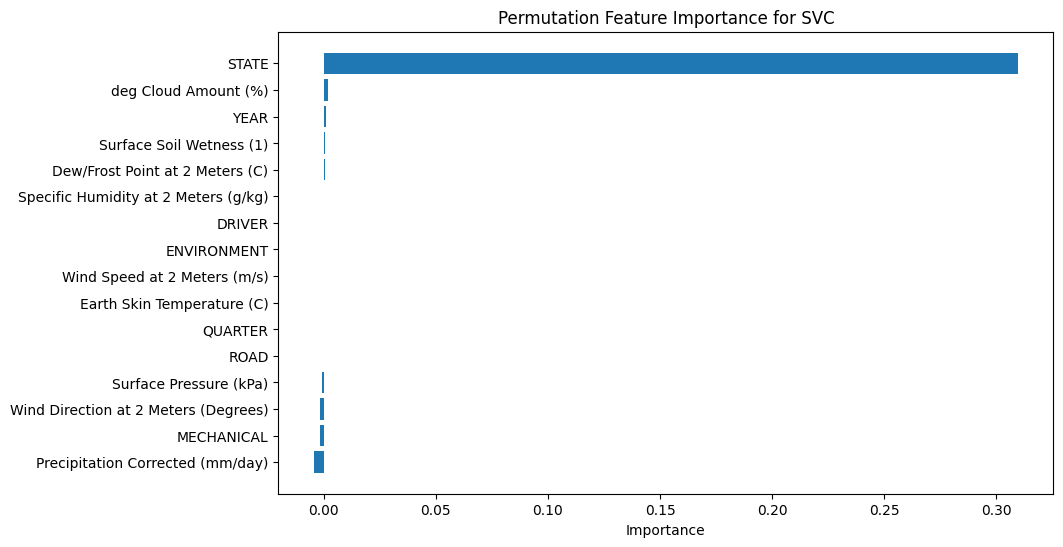

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Permutation Feature Importance for SVC')
plt.gca().invert_yaxis()
plt.show()


Looking at the SVC model’s feature importance, one thing immediately jumps out: STATE dominates everything. Its importance score of 0.31 is orders of magnitude higher than any other feature. Honestly, this isn’t too surprising. Nigerian roads vary wildly from state to state; driving behavior, enforcement, road quality, and accident reporting standards all differ. Lagos alone has chaotic traffic compared to, say, Ekiti or Enugu, and the model clearly picks up on these patterns.
Other features like cloud amount, year, soil wetness, and dew/frost point have tiny positive contributions, but their values are almost negligible in comparison. Interestingly, some weather and temporal features, even “specific humidity,” showed near-zero impact. We guess the SVC finds these less discriminative, at least for the sigmoid kernel used.
Some features even show negative contributions, such as precipitation, mechanical issues, and wind direction. These negative values don’t necessarily mean the feature is harmful; they might just indicate the model interprets small fluctuations in these variables as weak signals for severity prediction. Still, it highlights an interesting limitation: SVC with a sigmoid kernel is not inherently transparent, so some “importance” numbers can be noisy or hard to interpret.
Notably, core causative features like DRIVER, ENVIRONMENT, ROAD, and QUARTER scored zero. At first, this seems counterintuitive; we know driver errors and road conditions cause accidents every day. But reflecting on the dataset, it might be due to data granularity issues. Many Nigerian accident reports don’t consistently capture environmental conditions or detailed driver actions, so the model simply doesn’t have enough signal to assign importance to these features.
In real-world terms, this makes sense. You could have two accidents on the same road under similar weather conditions, one caused by a drunk driver, another by a sudden mechanical failure, but if the dataset doesn’t record all these nuances, the model can’t learn their impact.




In [ ]:

# Save encoder correctly
joblib.dump(best_model, open('svc_model.pkl', 'wb'))
joblib.dump(te, "state_encoder.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']